# Legalis Extractor

### Notebook used to extract features and create binary values to predict

## importing packages and dataset

#### install libaries with pip (needed for google colab)

In [1]:
!pip install datasets
!pip install openai
!pip install huggingface-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### imports and huggingface login

In [4]:
import datasets as ds #pulling/pushing dataset
import huggingface_hub
import time #waiting after failed API call
import os #enviroment variables for security reasonons
import openai #openai libary for chatgpt api
import pandas as pd #pandas for nicer data showcasing
import matplotlib.pyplot as plt

huggingface_hub.notebook_login()

#### import of split but not enhanced dataset

In [ ]:
dataset=ds.load_dataset("LennardZuendorf/openlegaldata-processed", split="three")
print(dataset)

#### import of already enhanced dataset for edits/updates

In [18]:
train=ds.load_dataset("LennardZuendorf/legalis", split="train")
test=ds.load_dataset("LennardZuendorf/legalis", split="test")
dataset = ds.concatenate_datasets([train,test])
#dataset = dataset.remove_columns(['label', 'winner'])

print(dataset)

Dataset({
    features: ['id', 'file_number', 'date', 'type', 'content', 'tenor', 'facts', 'reasoning', 'winner', 'label'],
    num_rows: 2801
})


In [19]:
print(dataset[10]['label'])

1


## Enhancing Dataset using OpenAI ChatGPT API by extracting winner and prediction label
#### using ChatGPT API to extract a winner from the tenor (summary), including a number label (0/1)

In [9]:
openai.api_key = os.getenv("openai_token")

#function to extract a label
def winner_extract(data):
  try:
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a legal scholar."},
        {"role": "user", "content":
                            "Extrahiere aus dem folgenden Tenor einer Gerichtsentscheidung den Gewinner der Entscheidung:"
                            +str(data['tenor'])+"Gib den Gewinner so aus: Gewinner: mit 1 für Kläger und 0 für Verklagter."
        }
      ]
    )
  except openai.error.RateLimitError as e:
    print(f"OpenAI API request exceeded rate limit: {e}")
    time.sleep(5)
    return winner_extract(data)
  except openai.error.ServiceUnavailableError as e:
    print(f"OpenAI API request exceeded rate limit: {e}")
    time.sleep(5)
    return winner_extract(data)
  except Exception as e:
    print(f"encountered unknown error: {e}")
    data['winner'] = "error"
    return data

  #extracting the answer
  data['winner']=completion.choices[0].message['content']
  return data


#batching dataset and running gpt in 100 batches
def batch_runner(data, batch_size, first_batch):
  #first batch
  print("running first batch "+str(0)+" to "+str(first_batch))
  output = ds.Dataset.from_dict(data[:first_batch])
  output = output.map(winner_extract)

  i=first_batch
  e=i+batch_size

  #batch running
  while i<len(data):
    print("running batch "+str(i)+" to "+str(e))

    tmp_data=ds.Dataset.from_dict(data[i:e])
    tmp_data=tmp_data.map(winner_extract)
    output = ds.concatenate_datasets([output, tmp_data])

    i=e
    e=i+batch_size

  return output

#### creating a binary label from the ChatGPT response and stripping down the text response in winner

In [21]:
#function to create binary label from the winner label
def winner_binary(data):
  winner = data['winner']

  #new label if winner is 1 (Klaeger) or 0 (Verklagter), else put other
  if "1" in winner or data['label']==1:
      data['label']=1
      data['winner']="Klaeger*in"
  elif "0" in winner or data['label']==0:
      data['label']=0
      data['winner']="Verklagte*r"
  elif "1" in winner and "0" in winner:
      data['label']=2
  else:
      data['label']=3

  return data

def filter_binary(data):
    if data['label']==2 or data['label']==3:
        return False
    else:
        return True

#### function to count success and distribution of case outcomes

In [7]:
def count_success(enhanced_dataset):

    success=0
    fail=0

    for case in dataset:
        if case['label']==1 or case['label']==0:
            success+=1
        elif case['label']==2 or case['label']==3:
            fail+=1

    dist=[round(success/(success+fail), 2),round(fail/(success+fail),2)]

    data={'Success': [success, dist[0]], 'Fails': [fail, dist[1]]}
    index=['label nmb.', 'label dist.']

    return pd.DataFrame(data=data, index=index)

def count_dist(dataset):

    counter_zero=0
    counter_one=0

    for case in dataset:
        if case['label']==1:
            counter_one+=1
        elif case['label']==0:
            counter_zero+=1

    dist=[round(counter_zero/(counter_zero+counter_one),2),round(counter_one/(counter_zero+counter_one),2)]

    data={'Verklagte*r': [counter_zero, dist[0]], 'Klaeger*in': [counter_one, dist[1]]}
    index=['case nmb.', 'case dist.']

    return pd.DataFrame(data=data, index=index)

In [29]:
def show_label_metrics(label_df):
    labels = label_df.columns
    values = label_df.iloc[0]

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Cases')
    ax.set_title('Distribution Sucess/Failure Enhancing')

    display(label_df)
    plt.show()

def show_case_metrics(case_df):
    cases = case_df.columns
    values = case_df.iloc[0]

    fig, ax = plt.subplots()
    ax.bar(cases, values)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Cases')
    ax.set_title('Outcome Distribution')

    display(case_df)
    plt.show()

#### running the enhancing function in batches (commented out to prevent it from running again accidently

In [23]:
#enhanced_dataset = batch_runner(dataset, 50, 28)
#enhanced_dataset = dataset

#### creating binary labels, filtering and displaying metrics for both

,Success,Fails
label nmb.,2801.0,0.0
label dist.,1.0,0.0


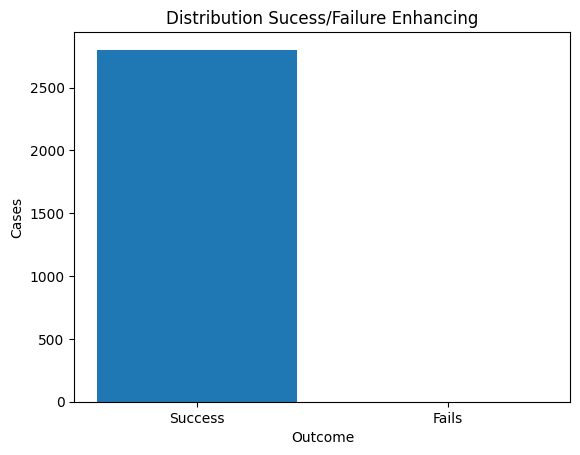

,Verklagte*r,Klaeger*in
case nmb.,1705.00,1096.00
case dist.,0.61,0.39


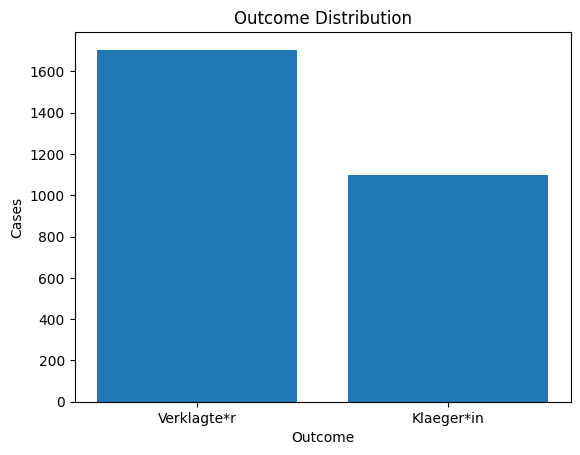

In [30]:
dataset=enhanced_dataset.map(winner_binary)
show_label_metrics(count_success(dataset))

dataset=dataset.filter(filter_binary)
show_case_metrics(count_dist(dataset))

## Creating Splits, Uploading the new Dataset to HuggingFace Datasets

#### creating traing/test split with datasets function, then pushing the dataset to the huggingface hub

In [ ]:
#uploading new dataset into different repository
dataset = dataset.train_test_split(test_size=0.05)
print(dataset)
dataset.push_to_hub("LennardZuendorf/legalis", token=os.environ['hub_token'])

DatasetDict({
    train: Dataset({
        features: ['id', 'file_number', 'date', 'type', 'content', 'tenor', 'facts', 'reasoning', 'winner', 'label'],
        num_rows: 2660
    })
    test: Dataset({
        features: ['id', 'file_number', 'date', 'type', 'content', 'tenor', 'facts', 'reasoning', 'winner', 'label'],
        num_rows: 141
    })
})


Pushing split train to the Hub.
Pushing split test to the Hub.
